In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gti-upm/leapgestrecog")

print("Path to dataset files:", path)

100%|██████████| 2.13G/2.13G [00:25<00:00, 90.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1


In [2]:
import os

dataset_path = '/root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1'
print("Directory exists:", os.path.exists(dataset_path))

Directory exists: True


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

# Path to dataset
dataset_path =  '/root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1' # Change this if your dataset is elsewhere

# Data augmentation and loading
image_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Model definition
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

# Fine-tuning
base_model.trainable = True  # Unfreeze base model for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

# Save the model for later use
model.save('/content/hand_symbol_model.h5')


Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 716s 708ms/step - accuracy: 0.5037 - loss: 0.9358 - val_accuracy: 0.5024 - val_loss: 0.7020
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 706s 705ms/step - accuracy: 0.4918 - loss: 0.7031 - val_accuracy: 0.4985 - val_loss: 0.6951
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 745s 708ms/step - accuracy: 0.5005 - loss: 0.6977 - val_accuracy: 0.5044 - val_loss: 0.6939
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 733s 700ms/step - accuracy: 0.5011 - loss: 0.6957 - val_accuracy: 0.5033 - val_loss: 0.6940
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 695s 694ms/step - accuracy: 0.4880 - loss: 0.6951 - val_accuracy: 0.4975 - val_loss: 0.6934
Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2150s 2s/step - accuracy: 0.4965 - loss: 0.6932 - val_accuracy: 0.5063 - val_loss: 0.6932
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2109s 2s/step - accuracy: 0.4999 - loss: 0.6931 - val_accuracy: 0.4914 - val_loss: 0.6933
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2115s 2s/step - accuracy: 0.4985 - loss: 0

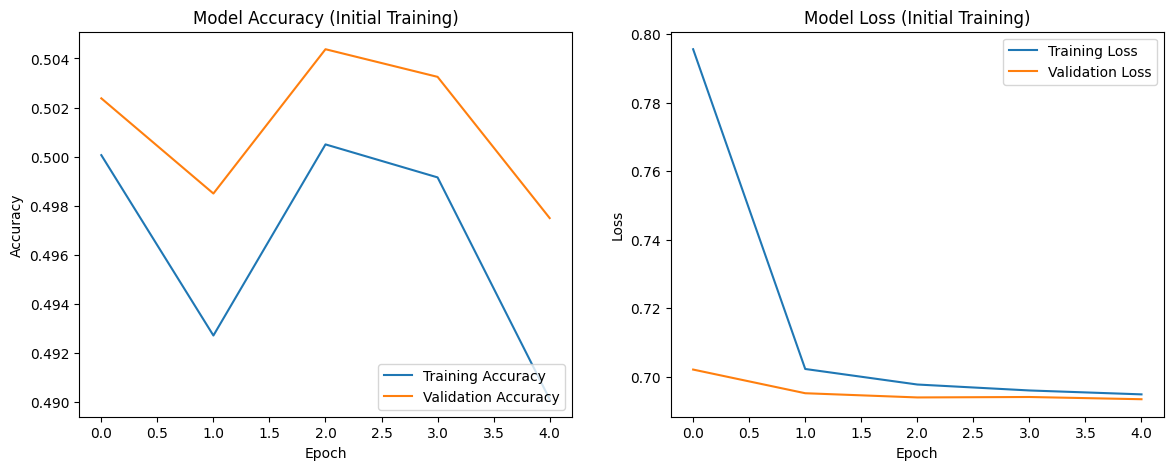

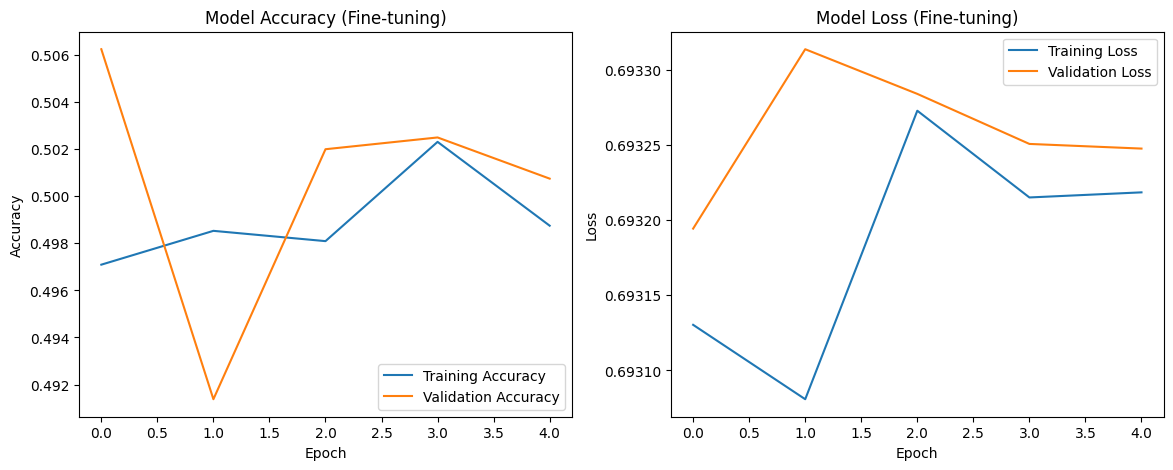

In [4]:
import matplotlib.pyplot as plt

# Plotting function for training and validation accuracy/loss
def plot_history(history, title_suffix=""):
    # Accuracy plot
    plt.figure(figsize=(14, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()

# Plot initial training history
plot_history(history, title_suffix="(Initial Training)")

# Plot fine-tuning training history
plot_history(history_fine, title_suffix="(Fine-tuning)")

In [5]:
def plot_history(history, title_suffix=""):
    # Import matplotlib if not already imported
    import matplotlib.pyplot as plt

    # Accuracy plot
    plt.figure(figsize=(6, 3))  # Made it even smaller

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()  # Improves subplot spacing
    plt.show()